# Inception V3 Based Model

In [1]:
# Імпорт бібліотек
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers

In [2]:
# Імпорт вхідних даних і функцій для візуалізацій
from notebooks.load_dataset.load_dataset import x_test, y_test, x_train, y_train

from results.functions import history_plot, visualize_predictions

e:\Goit\projects\Data_Science_core\final_data_project\ds_project


## Замороження шарів базової моделі

In [3]:
conv_base = InceptionV3(weights='imagenet', include_top=False)
conv_base.trainable = False

## Додавання шарів входу та класифікатора до базової моделі

In [4]:
model = keras.models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Rescaling(1. / 255),
    layers.Resizing(224, 224),
    conv_base,
    layers.Flatten(),
    layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [6]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint("../models/inception_v3.keras", save_best_only=True, monitor="val_loss", verbose=2),
    keras.callbacks.EarlyStopping(patience=10, verbose=2),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
]

## Виділення ознак

In [8]:
history = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2, callbacks=callbacks)

Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 2.6806 - accuracy: 0.4129
Epoch 1: val_loss improved from inf to 1.27892, saving model to ../models\inception_v3.keras
313/313 [==============================] - 65s 176ms/step - loss: 2.6806 - accuracy: 0.4129 - val_loss: 1.2789 - val_accuracy: 0.7811 - lr: 1.0000e-04
Epoch 2/100
313/313 [==============================] - ETA: 0s - loss: 1.4738 - accuracy: 0.6711
Epoch 2: val_loss improved from 1.27892 to 0.99298, saving model to ../models\inception_v3.keras
313/313 [==============================] - 53s 169ms/step - loss: 1.4738 - accuracy: 0.6711 - val_loss: 0.9930 - val_accuracy: 0.8222 - lr: 1.0000e-04
Epoch 3/100
313/313 [==============================] - ETA: 0s - loss: 1.2006 - accuracy: 0.7477
Epoch 3: val_loss improved from 0.99298 to 0.88971, saving model to ../models\inception_v3.keras
313/313 [==============================] - 52s 166ms/step - loss: 1.2006 - accuracy: 0.7477 - val_loss: 0.8897 - val_acc

In [9]:
# Завантаження моделі
model = keras.models.load_model("models/inception_v3.keras")

In [10]:
# Результати на тестовій вибірці
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print(f"Test accuracy: {test_acc:.3f}")

313/313 - 13s - loss: 0.8114 - accuracy: 0.8522 - 13s/epoch - 43ms/step
Test accuracy: 0.852


1/1 [==============================] - 2s 2s/step
 Labels:      [3 3 0 5 7 0 8 0 0 9 2 2 3 4 8]
 Predictions: [3 3 0 5 7 0 8 0 0 9 2 2 3 4 0]


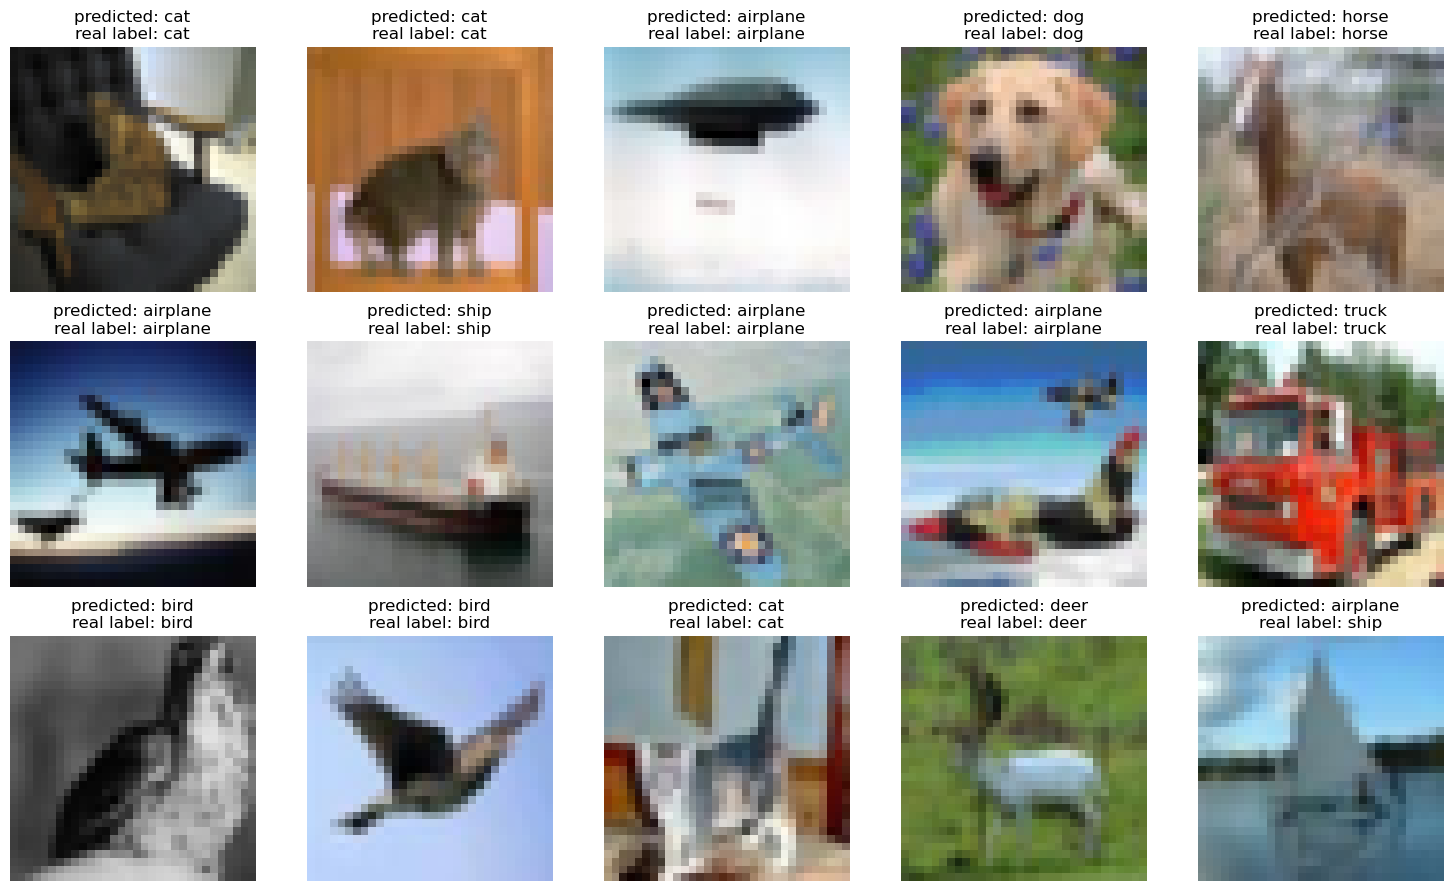

In [11]:
# Перегляд візуалізацій результатів
visualize_predictions(model)

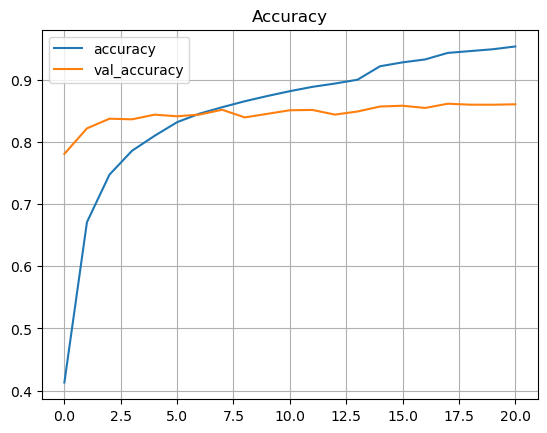

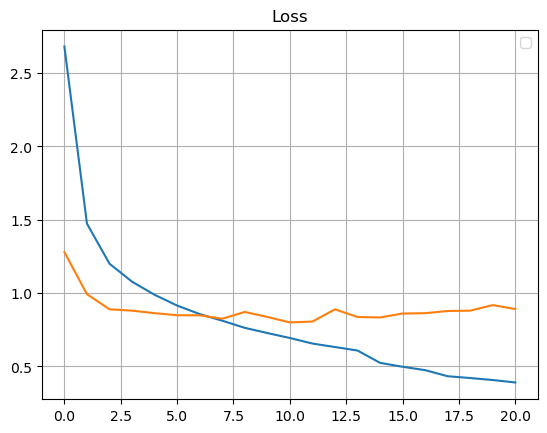

In [12]:
# Перегляд графіків точності і втрат
history_plot(history)

## Донавчання

### Розмороження верхніх шарів базової моделі

In [13]:
for layer in conv_base.layers[-4:]:
    if layer.name.startswith("mix"):
        layer.trainable = True
        print(layer.name, layer.trainable)

mixed9_1 True
mixed10 True


In [14]:
# Визначаємо оптимізатор, функцію втрат і метрику моделі
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [15]:
# Задаємо точки збереження моделі
callbacks[0] = keras.callbacks.ModelCheckpoint("models/inception_v3_finetune.keras", save_best_only=True,

                                               monitor="val_loss", verbose=2)

In [16]:
# Натренуємо модель
history_tuned = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2, callbacks=callbacks)

Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.9139
Epoch 1: val_loss improved from inf to 0.80810, saving model to ../models\inception_v3_finetune.keras
313/313 [==============================] - 57s 169ms/step - loss: 0.5819 - accuracy: 0.9139 - val_loss: 0.8081 - val_accuracy: 0.8576 - lr: 1.0000e-05
Epoch 2/100
313/313 [==============================] - ETA: 0s - loss: 0.5657 - accuracy: 0.9181
Epoch 2: val_loss improved from 0.80810 to 0.80772, saving model to ../models\inception_v3_finetune.keras
313/313 [==============================] - 52s 167ms/step - loss: 0.5657 - accuracy: 0.9181 - val_loss: 0.8077 - val_accuracy: 0.8604 - lr: 1.0000e-05
Epoch 3/100
313/313 [==============================] - ETA: 0s - loss: 0.5566 - accuracy: 0.9194
Epoch 3: val_loss improved from 0.80772 to 0.80757, saving model to ../models\inception_v3_finetune.keras
313/313 [==============================] - 53s 169ms/step - loss: 0.5566 - accuracy: 0.9194 -

In [17]:
# Завантажимо модель
model = keras.models.load_model("models/inception_v3_finetune.keras")

In [18]:
# Перевірка на тестових даних
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print(f"Test accuracy: {test_acc:.3f}")

313/313 - 13s - loss: 0.8259 - accuracy: 0.8581 - 13s/epoch - 40ms/step
Test accuracy: 0.858


1/1 [==============================] - 1s 1s/step
 Labels:      [6 0 2 4 1 3 6 7 7 4 4 3 3 4 5]
 Predictions: [6 0 2 7 1 3 6 7 7 4 4 3 3 4 3]


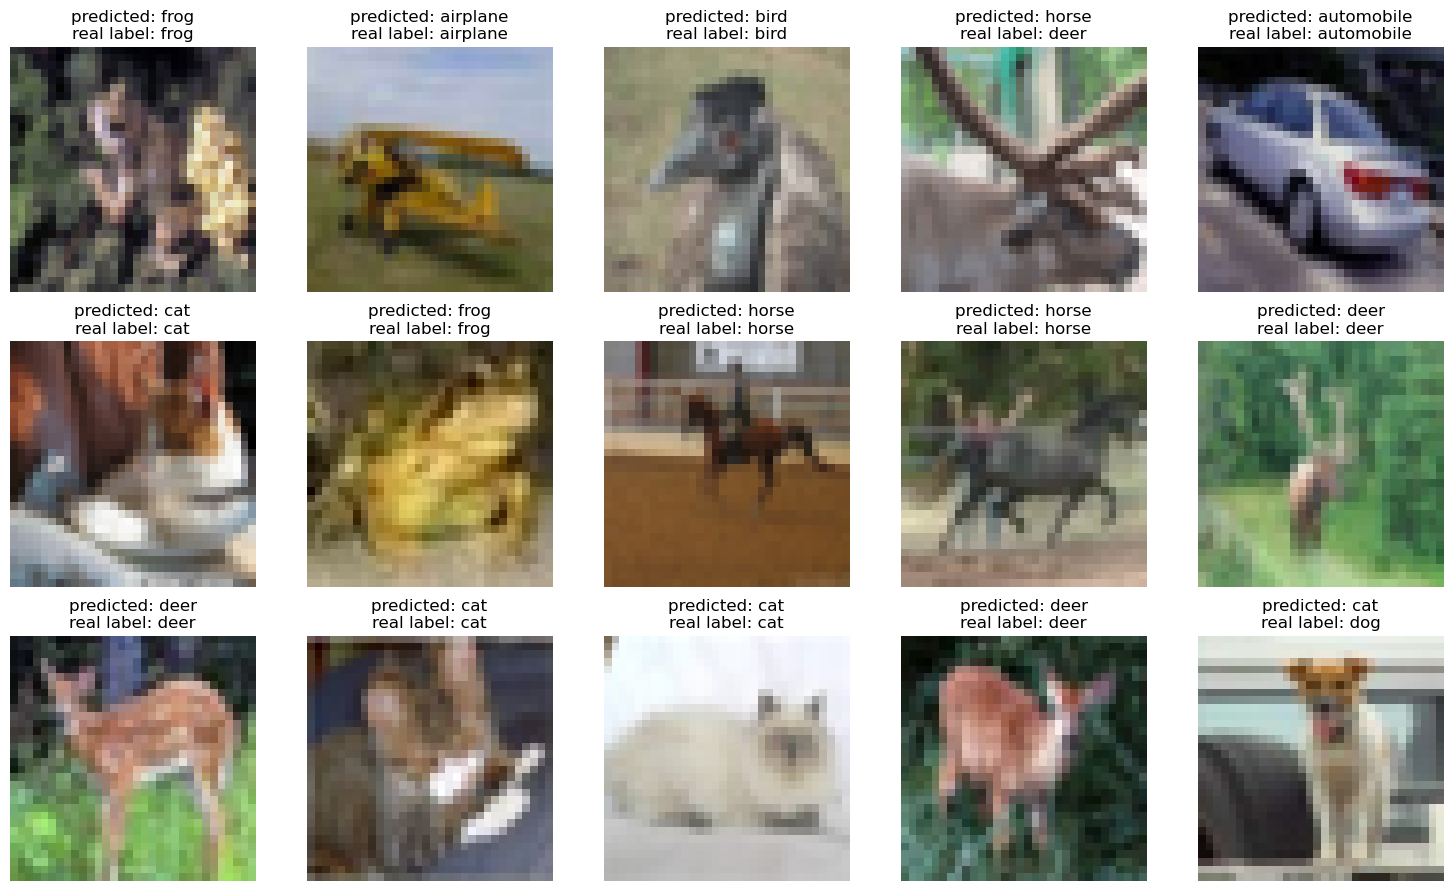

In [19]:
# Візуалізація результатів
visualize_predictions(model)

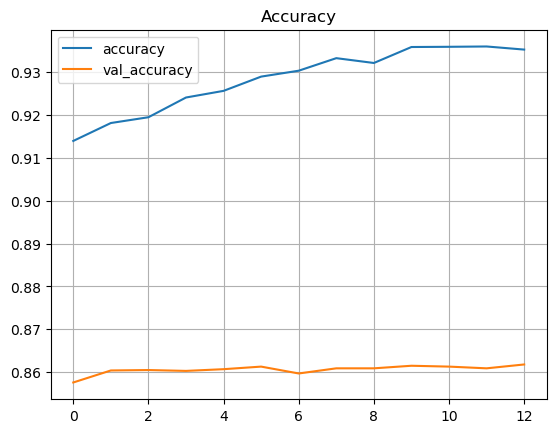

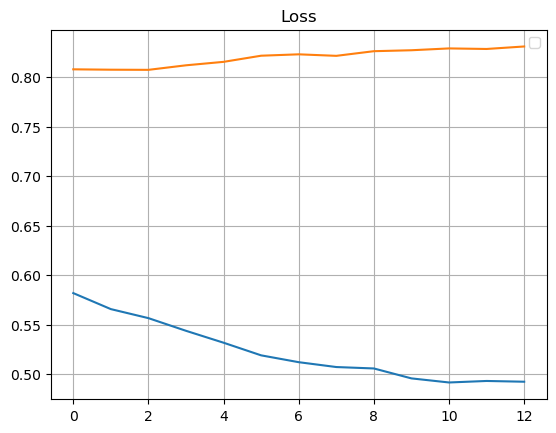

In [20]:
# Графік точності і втрат
history_plot(history_tuned)

## Висновок:

&nbsp;&nbsp;&nbsp;&nbsp;Використання моделі Inception V3 в якості згорткової бази для нейронної моделі, призначеної для розпізнавання класів зображень, натренованої на датасеті CIFAR-10 з замороженими шарами згорткової основи, оптимізатором RMSprop lr=0.0001 і колбеку ReduceLROnPlateau для запобігання застрягання в локальних мінімумах, дозволило досягнути результату 0.852 точності на тестових даних, та 0.954 на тренувальних. Також було використано регуляризатор L2(0.001) для всіх повнозв'язних шарів класифікатора.\

 &nbsp;&nbsp;&nbsp;&nbsp;Спроба донавчання з невеликою кількістю розморожених верхніх шарів основи та зменшеною до 0.00001 швидкістю навчання привело до незначного покращення результатів - 0.858 на тестових даних. При цьому спостерігаються деякі ознаки перенавчання.     



313/313 [==============================] - 680s 2s/step
Клас 0 (airplane): правильно класифіковано 835 з 1000 (83.50%)
Клас 1 (automobile): правильно класифіковано 946 з 1000 (94.60%)
Клас 2 (bird): правильно класифіковано 810 з 1000 (81.00%)
Клас 3 (cat): правильно класифіковано 731 з 1000 (73.10%)
Клас 4 (deer): правильно класифіковано 871 з 1000 (87.10%)
Клас 5 (dog): правильно класифіковано 836 з 1000 (83.60%)
Клас 6 (frog): правильно класифіковано 855 з 1000 (85.50%)
Клас 7 (horse): правильно класифіковано 833 з 1000 (83.30%)
Клас 8 (ship): правильно класифіковано 910 з 1000 (91.00%)
Клас 9 (truck): правильно класифіковано 895 з 1000 (89.50%)


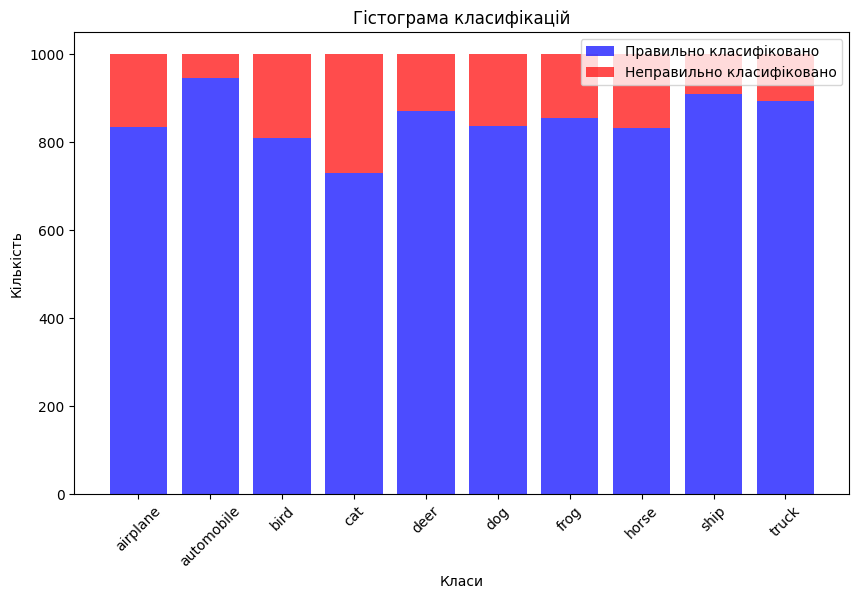

In [3]:
# Перевіримо на яких классах модель помиляється частіше
from results.functions import calculate_percent_right_mob

model = keras.models.load_model("models/inception_v3.keras")

calculate_percent_right_mob(x_test, y_test, model=model)